# Comparison of an SMPI trace with a real trace for HPL

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(b'State')]
    return b'\n'.join(lines)

def read_mpi_csv(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function'],
                  filter_func=filter_pajeng)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    df['rank'] = df['rank'].abs()  # for some reason, Simgrid uses rank-42 and not rankd42
    df['function'] = df['function'].str.replace('PMPI', 'MPI')  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    return df

def read_archive(archive_name, mode, max_time):
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank']]
    blas_trace['kind'] = 'BLAS'
    mpi_trace = read_mpi_csv(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[df['end'] <= max_time]
    print('\tRemoved %d events that happened after the resolution (e.g., HPL verifications)' % (old_len - len(df)))
    return df

reality_file = 'grenoble_2018-10-19_1813087.zip'
simgrid_file = '../smpi_hpl/grenoble_2018-10-19_1813088.zip'

simgrid_time = read_csv(simgrid_file, 'results.csv')['time'].unique()
reality_time = read_csv(reality_file, 'results.csv')['time'].unique()
assert len(simgrid_time) == 1 and len(reality_time) == 1
simgrid_time = simgrid_time[0]
reality_time = reality_time[0]

trace_reality = read_archive(reality_file, 'reality', reality_time)
trace_simgrid = read_archive(simgrid_file, 'simgrid', simgrid_time)
traces = pandas.concat([trace_reality, trace_simgrid])

traces.head()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Mode: reality
	BLAS trace:  34954 lines
	MPI  trace: 191108 lines
	Removed 111459 events that happened after the resolution (e.g., HPL verifications)
# Mode: simgrid
	BLAS trace:  27898 lines
	MPI  trace: 175547 lines
	Removed 1275 events that happened after the resolution (e.g., HPL verifications)


,function,start,end,rank,kind,mode,rank+1
0,dtrsm,-0.000039,0.000000,0,BLAS,reality,1
1,dgemm,0.000011,0.000139,0,BLAS,reality,1
2,dtrsm,0.000324,0.000325,0,BLAS,reality,1
3,dgemm,0.000328,0.000329,0,BLAS,reality,1
4,dtrsm,0.000332,0.000333,0,BLAS,reality,1


## Checking the parameters

In [2]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,8,32,1,2,2,1,0,8,32,1


In [3]:
read_csv(simgrid_file, 'exp_smpi.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,250000,128,8,32,1,2,2,1,0,8,32,1,6.484604e-11,0.00024,8.021068e-11,6.929164e-07


In [4]:
print(zipfile.ZipFile(simgrid_file).read('dahu.xml').decode('ascii'))

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

## Visualizing the traces

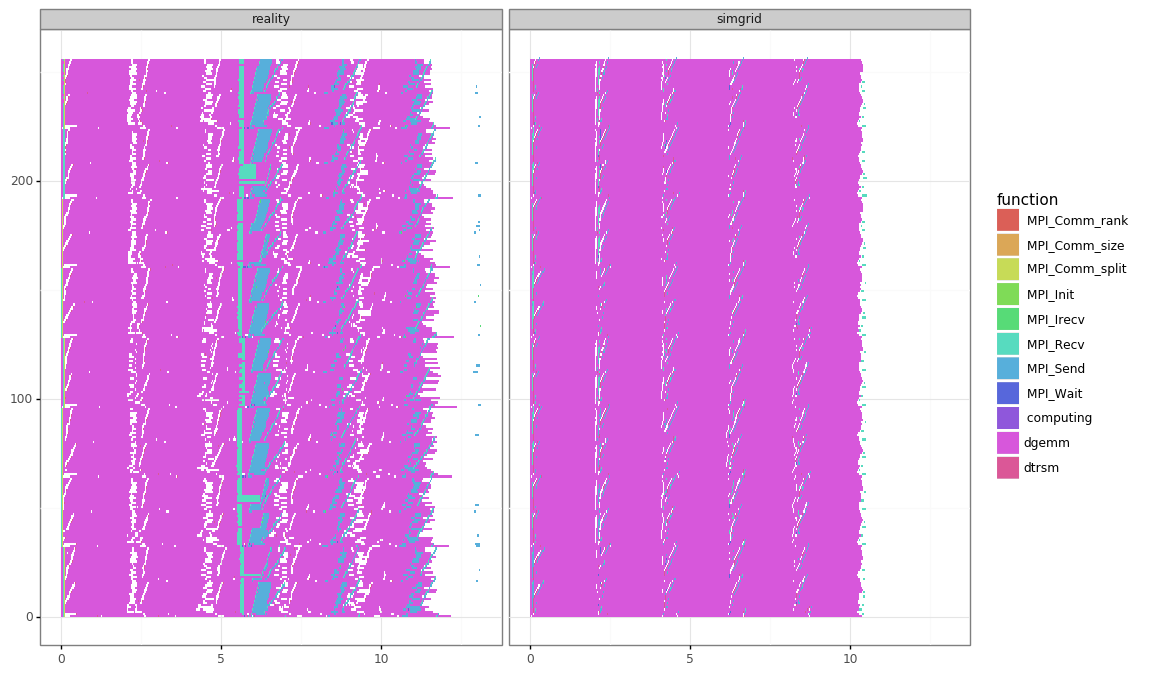

<ggplot: (-9223363260604937756)>

In [5]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

plot(traces, ['mode'])

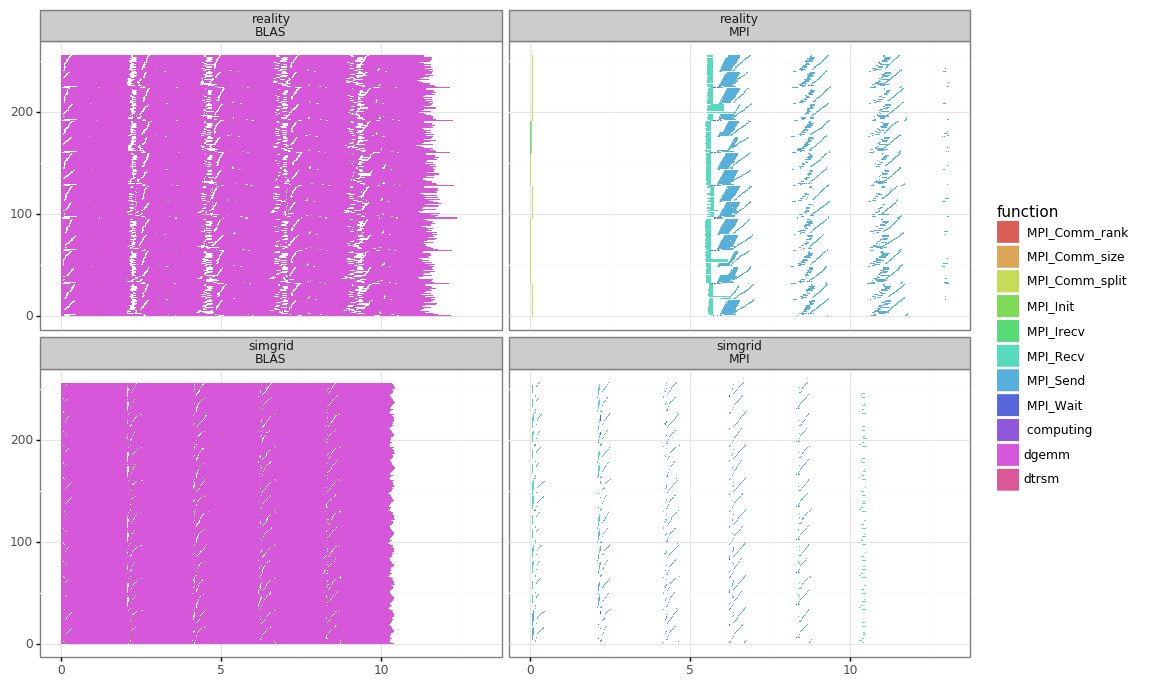

<ggplot: (8776153055741)>

In [6]:
plot(traces)

In [7]:
def plot_bounded(df, start, end, ranks):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

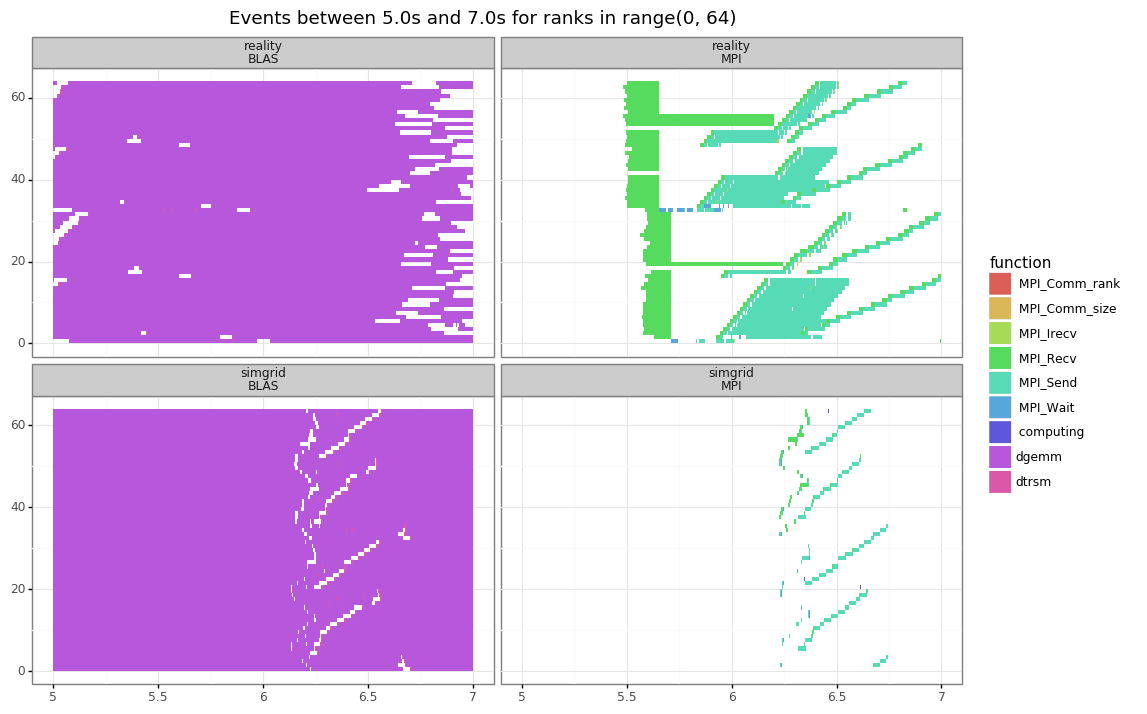

<ggplot: (-9223363260711242415)>

In [8]:
plot_bounded(traces, 5, 7, range(64))

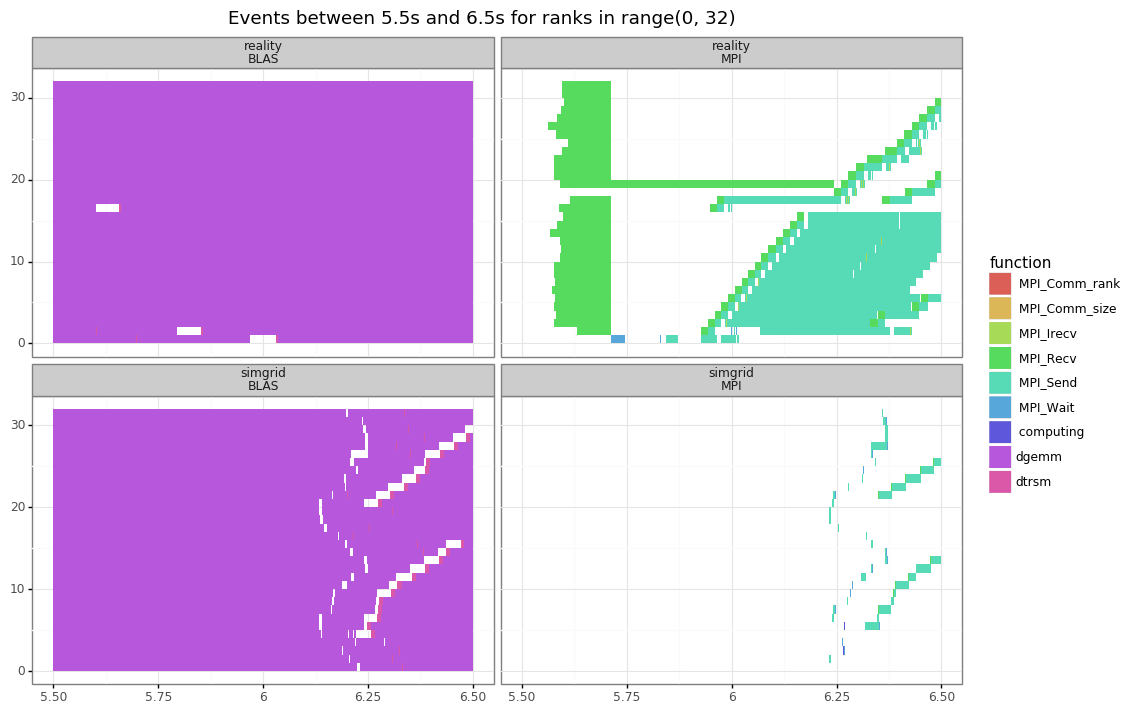

<ggplot: (-9223363260711592995)>

In [9]:
plot_bounded(traces, 5.5, 6.5, range(32))

## Plotting the total time spent in each function

In [10]:
def plot_total_duration(df, function, ranks):
    df = df[(df.function == function) & (df['rank'].isin(ranks))][['rank', 'mode', 'start', 'end']].copy()
    df['duration'] = df['end'] - df['start']
    df = df.groupby(['rank', 'mode']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='mode')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    print(plot)
    df_reality = df[df['mode'] == 'reality']
    df_simgrid = df[df['mode'] == 'simgrid']
    df = df_reality.set_index('rank').join(df_simgrid.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*35, y=max_diff*1.05) + annotate('segment', x=max_rank+shift*5, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

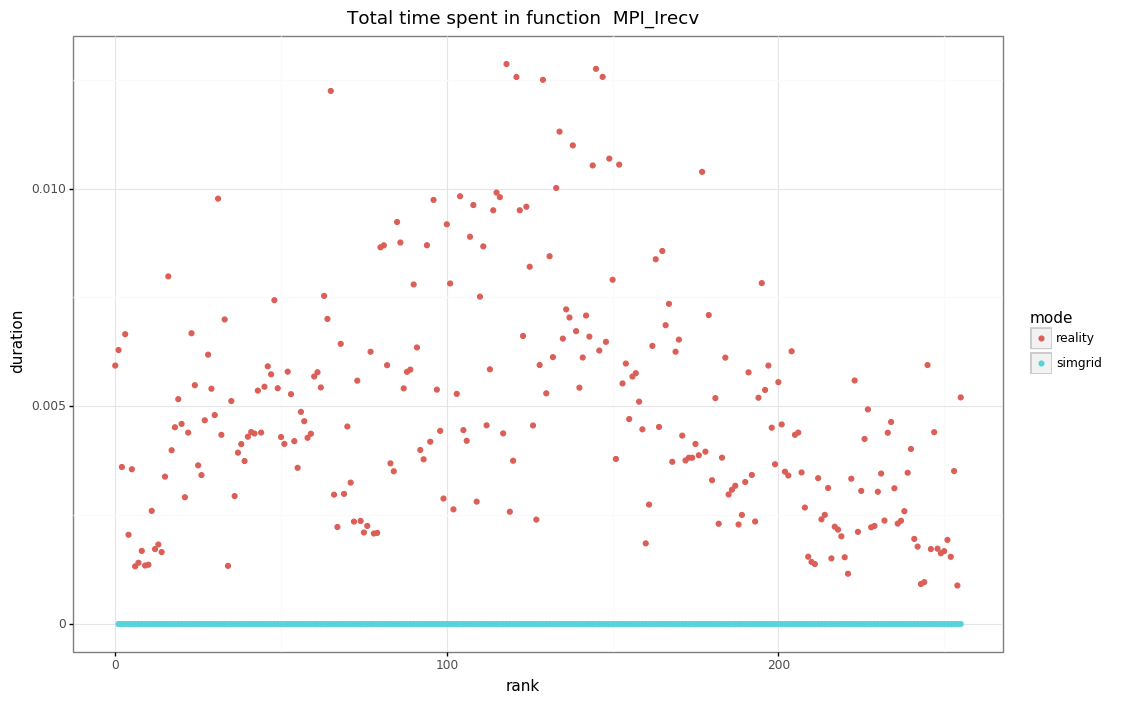

<ggplot: (-9223363260604930360)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


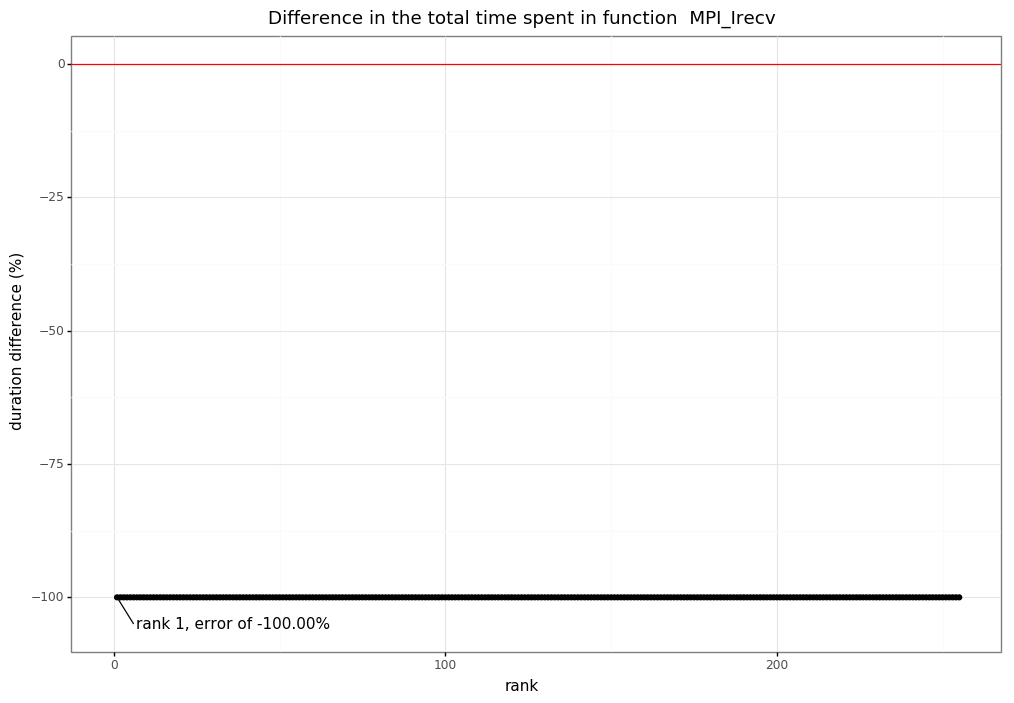

<ggplot: (-9223363260701522863)>


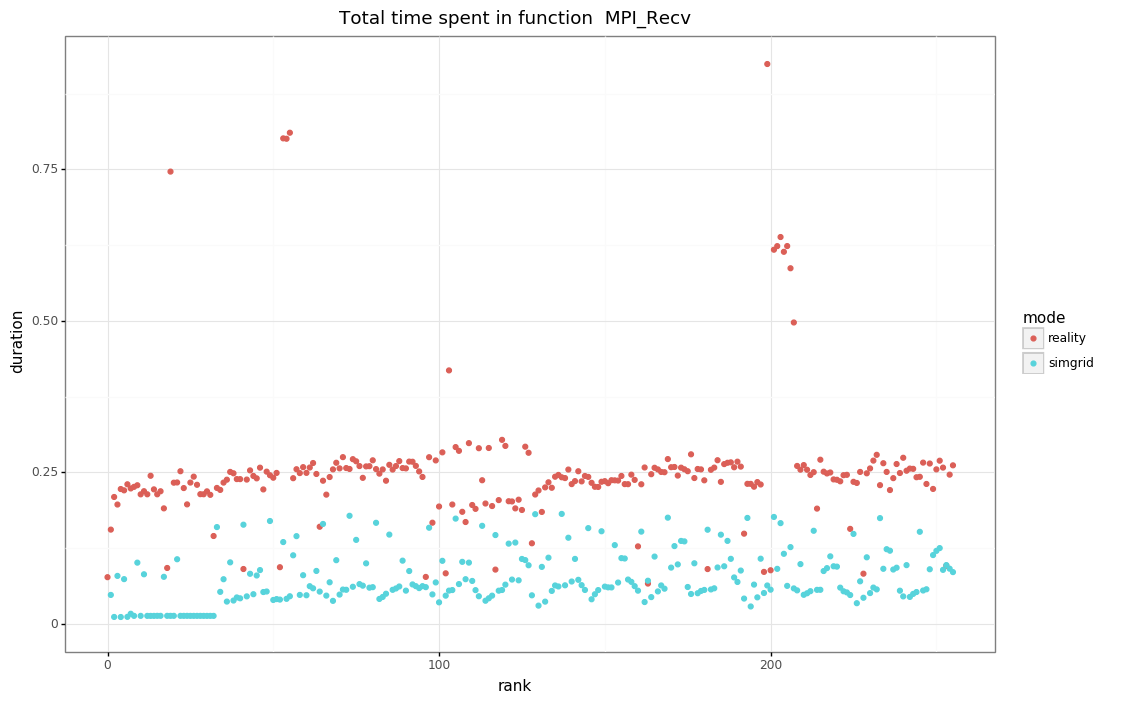

<ggplot: (8776153247026)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


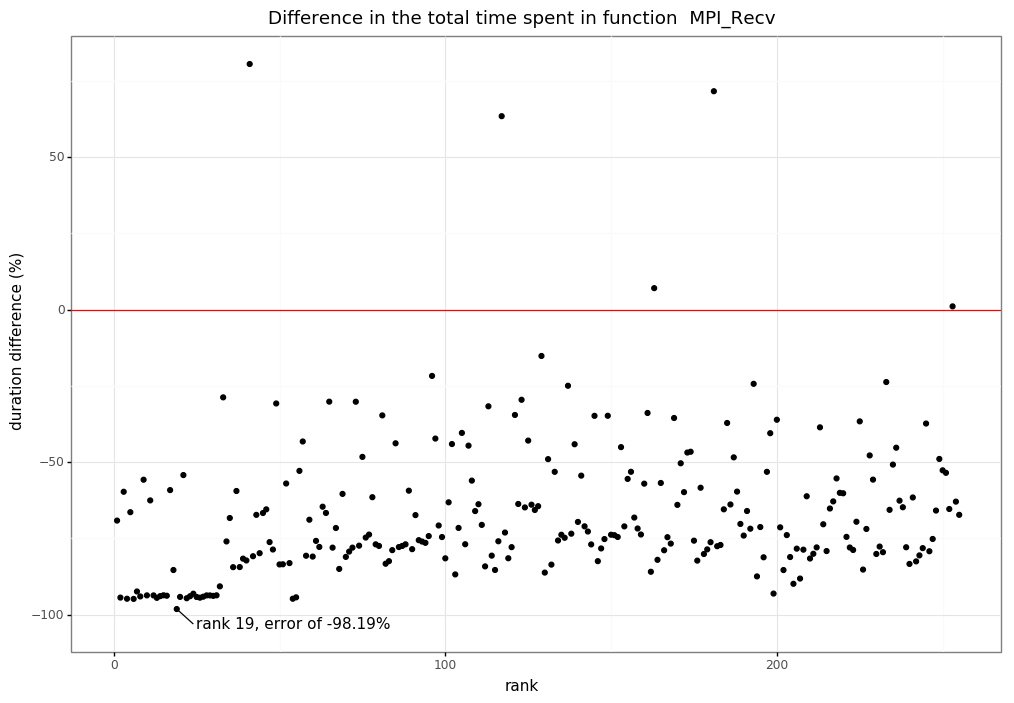

<ggplot: (-9223363260701586358)>


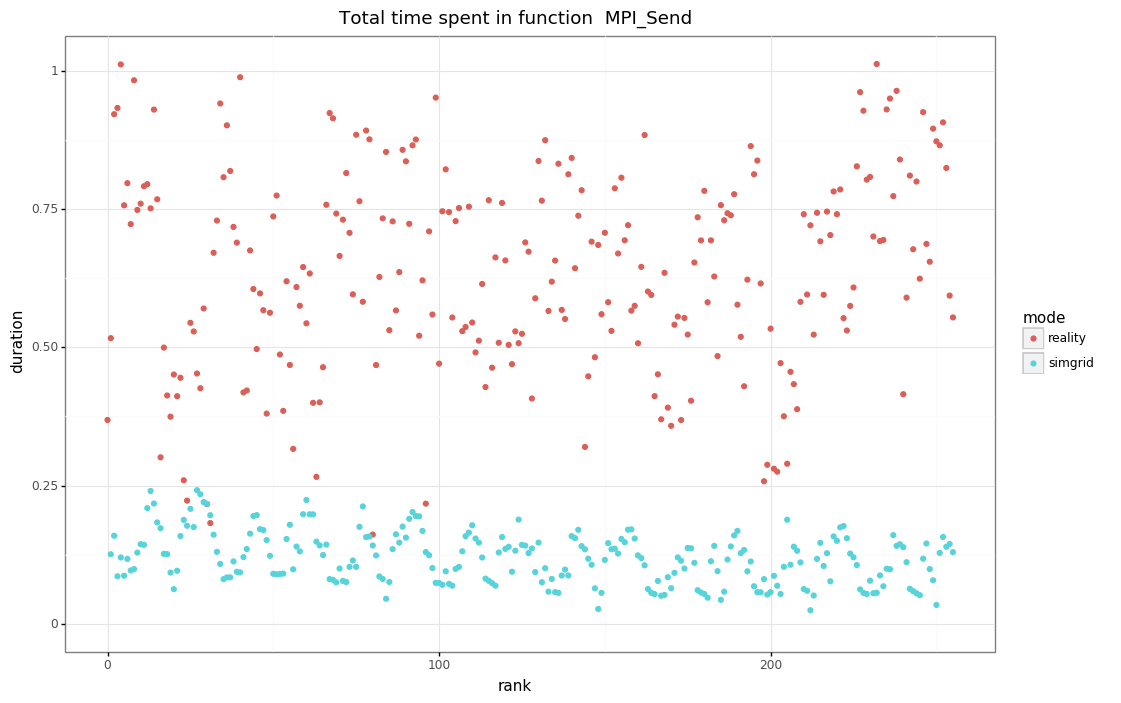

<ggplot: (-9223363260701586958)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


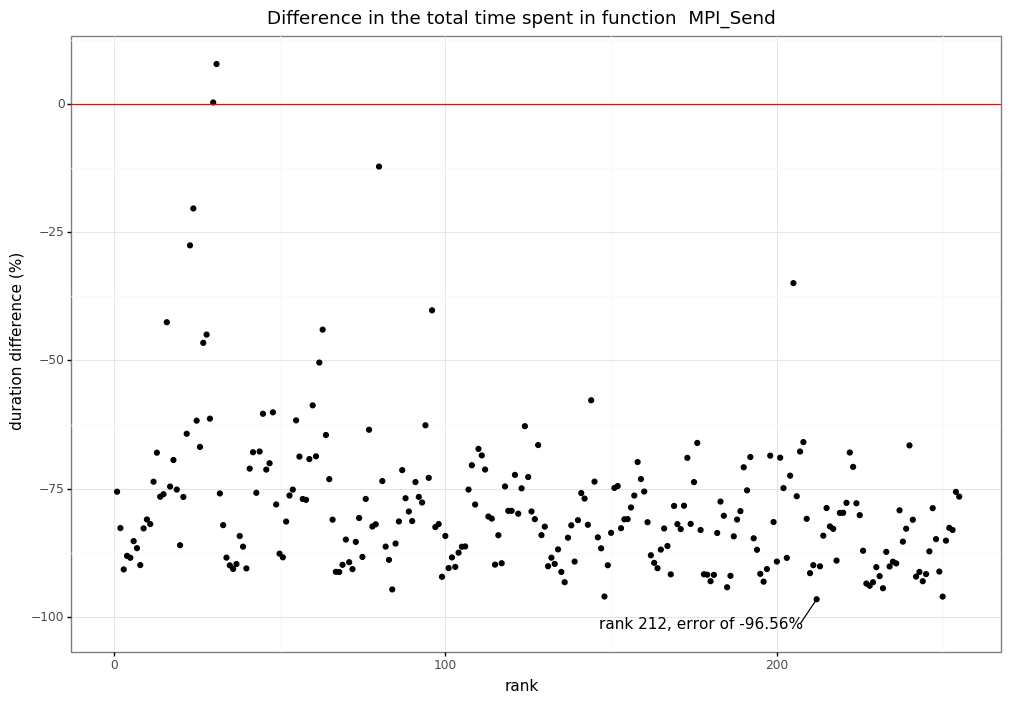

<ggplot: (8776153186126)>


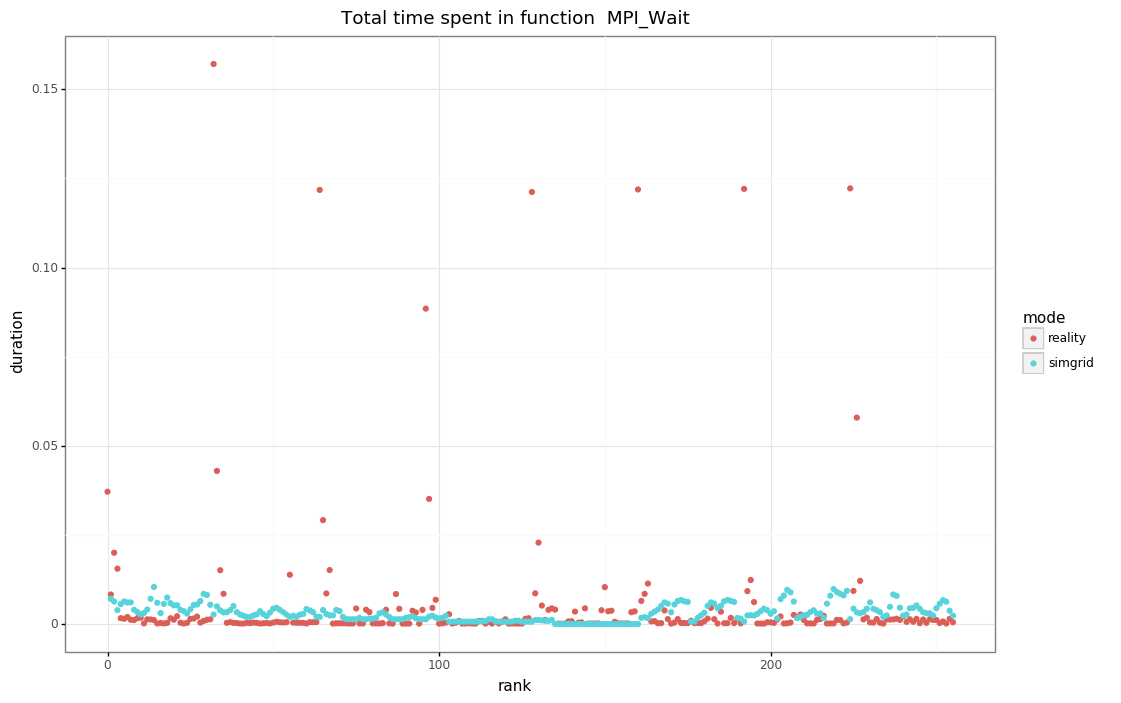

<ggplot: (-9223363260704349573)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


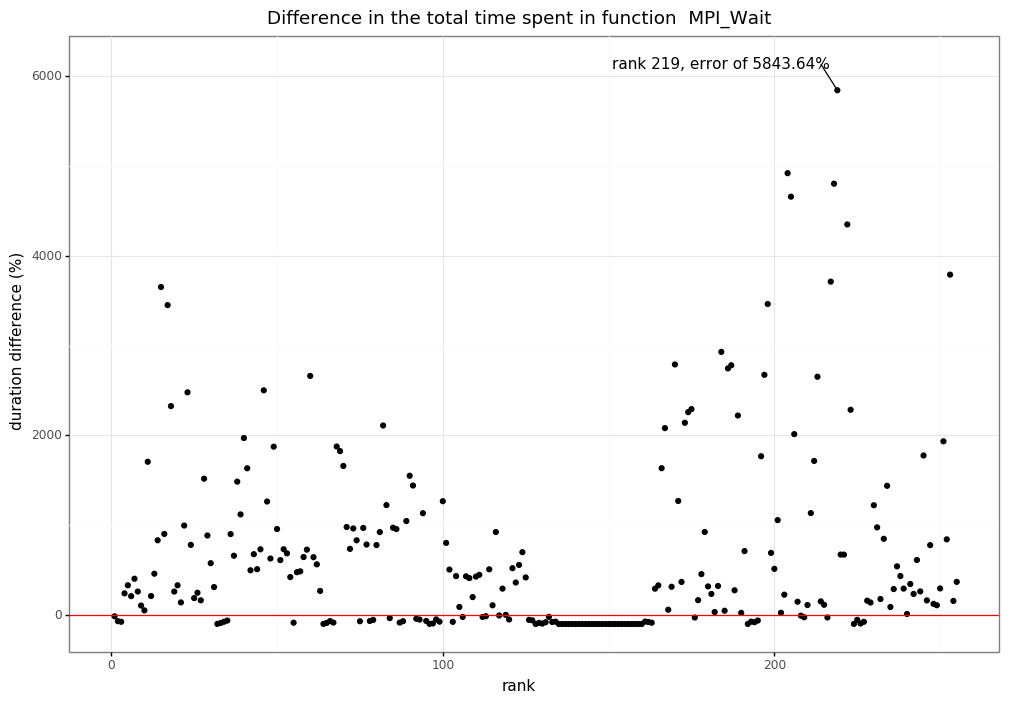

<ggplot: (-9223363260701618074)>


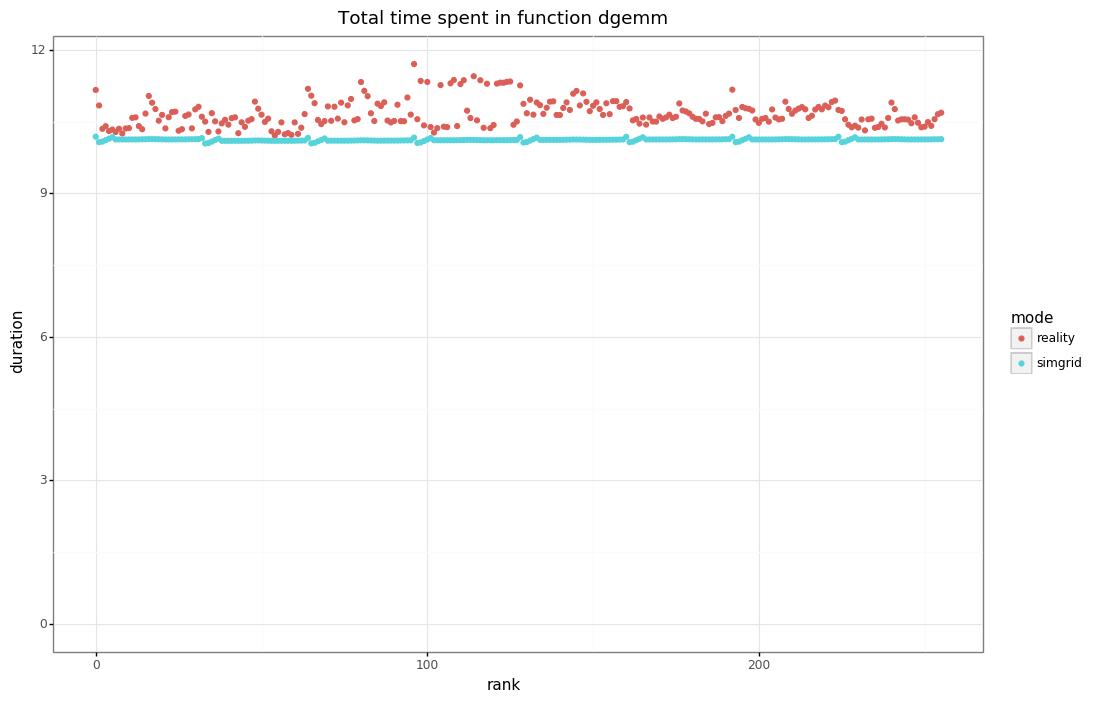

<ggplot: (-9223363260701620557)>


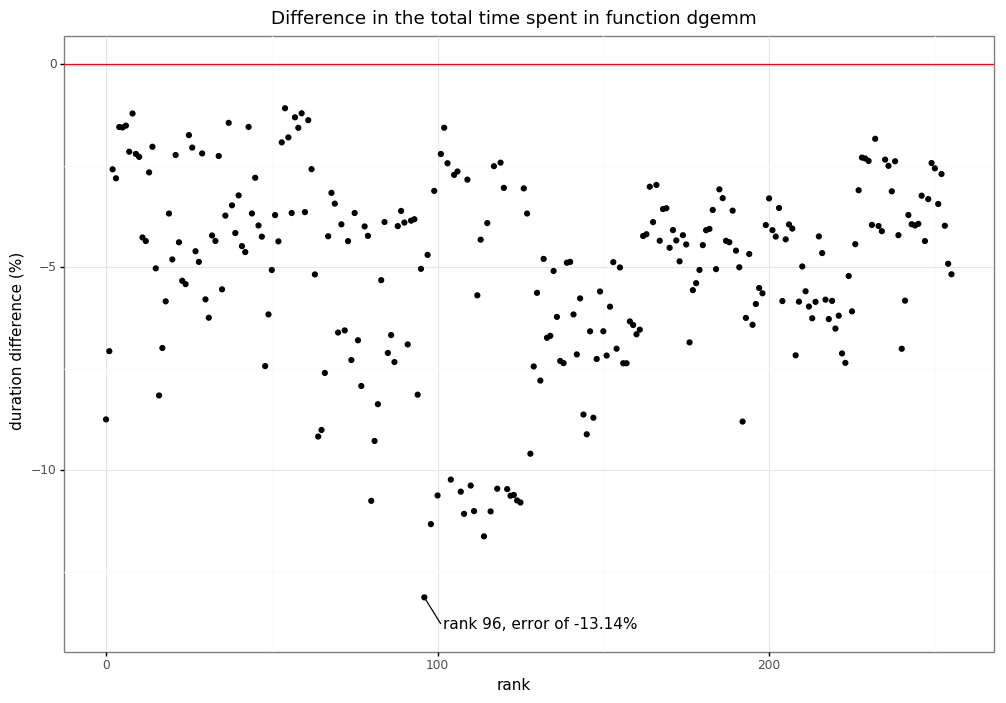

<ggplot: (8776153034097)>


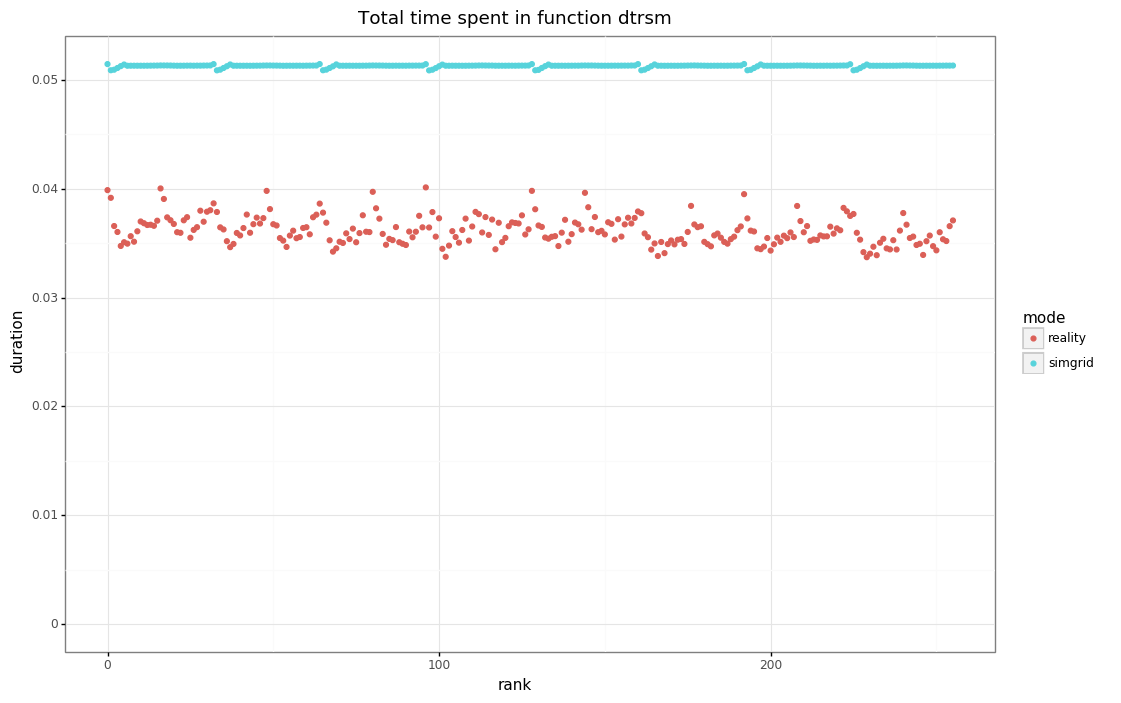

<ggplot: (8776153030825)>


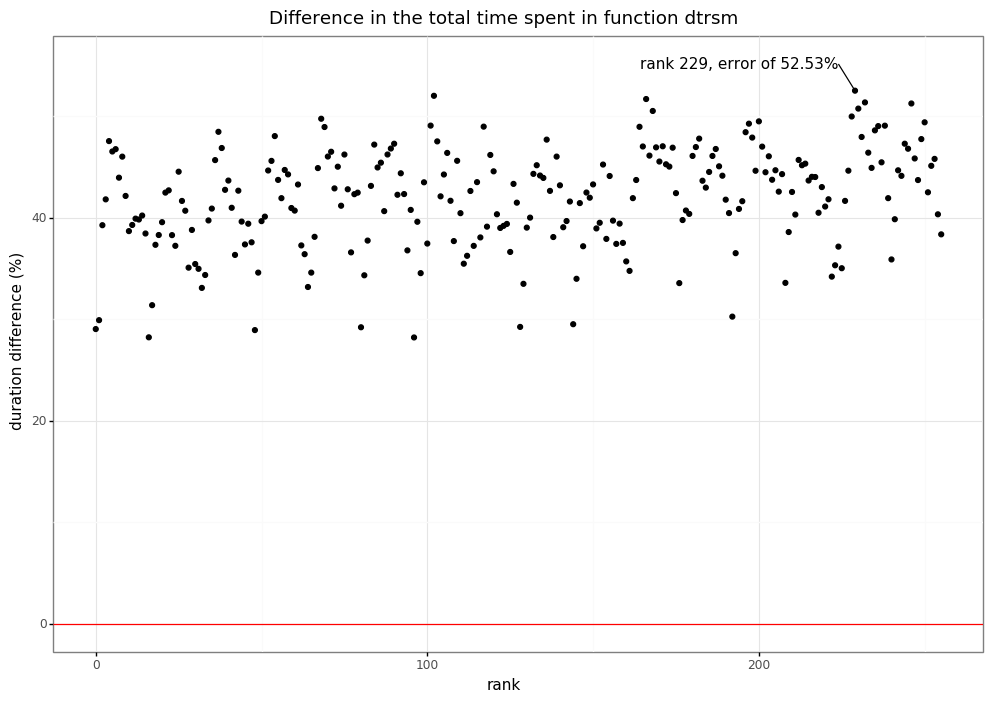

<ggplot: (8776152912269)>


In [11]:
for func in sorted(set(trace_reality.function.unique()) & set(trace_simgrid.function.unique())):
    plot_total_duration(traces, func, range(256))